This notebook conducts exporatory data analysis and hypothesis testing on a dataframe of recipe page information from Allrecipes.com. 

Data was scraped using the "allrecipes_scraper.py" script in this repo.
Data was tabulated into a dataframe using the "create_dataframe.py" script in this repo.


In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import json
import numpy.random as random
import os
import scipy

In [202]:
path = '/Users/kaelynnrose/Documents/GALVANIZE/Capstones/Capstone_1/data/allrecipes_dataframe.csv'
df = pd.read_csv(path,low_memory=False) # import recipe data csv as a dataframe

In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38158 entries, 0 to 38157
Data columns (total 72 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       38158 non-null  object 
 1   @context                         38158 non-null  object 
 2   @type                            38158 non-null  object 
 3   itemListElement                  1 non-null      object 
 4   mainEntityOfPage                 38142 non-null  object 
 5   name                             38158 non-null  object 
 6   datePublished                    38142 non-null  object 
 7   description                      38142 non-null  object 
 8   prepTime                         34633 non-null  object 
 9   cookTime                         28846 non-null  object 
 10  totalTime                        34852 non-null  object 
 11  recipeYield                      38138 non-null  object 
 12  recipeIngredient  

In [204]:
# clean dataframe

def clean_dataframe(unclean_df):

    df = unclean_df.copy()
    
    # remove any rows of data that are not of 'recipe' type
    df = df[df['@type'] == 'Recipe']
    
    # delete null columns
    df = df.dropna(axis=1,how='all')
    
    # delete any duplicate rows based on page url
    df = df.drop_duplicates(subset=['mainEntityOfPage'])
    
    # clean the categories column
    df['recipeCategory'] = [string.replace('[','').replace(']','').replace('\'','').split(', ') for string in df.recipeCategory] # convert string of categories to list
    
    # remove extra characters from nlp_sentiment_label column
    df['nlp_sentiment_label'] = df['nlp_sentiment_label'].str.replace('neutral"','neutral')
    
    # remove any rows with formatting errors in the creation date
    df = df[df['created_date'].str.contains('Z')]
    
    # transform created_date from string to datetime object
    df['created_date'] = pd.to_datetime(df['created_date'])
    
    return df

In [205]:
df = clean_dataframe(df)

In [118]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 38096 entries, 17 to 38156
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   Unnamed: 0                     38096 non-null  object             
 1   @context                       38096 non-null  object             
 2   @type                          38096 non-null  object             
 3   mainEntityOfPage               38096 non-null  object             
 4   name                           38096 non-null  object             
 5   datePublished                  38096 non-null  object             
 6   description                    38096 non-null  object             
 7   prepTime                       34606 non-null  object             
 8   cookTime                       28823 non-null  object             
 9   totalTime                      34825 non-null  object             
 10  recipeYield          

Now that we have a cleaned dataframe, it's time to do some exploratory data analysis. 


In [153]:
##### Health keywords in Recipe Descriptions

# create a list of dataframes where each dataframe has the recipes from one year
def yearly_dataframe(startyear,endyear,df):
    years = np.arange(startyear,endyear)
    yearly = []
    for year in years:
        startdate = str(year) + '-01-01'
        enddate = str(year) + '-12-31'
        yearly.append(df[(df['created_date'] > startdate) &(df['created_date'] < enddate)])
    return [yearly, years]


In [154]:
yearly, years = yearly_dataframe(1997,2022,df)
print('Divided dataframe into years: ')
print(years)

Divided dataframe into years: 
[1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]


In [155]:
len(yearly)

25

In [130]:
healthwords = np.zeros((6,len(yearly))) # initialize a blank matrix for healthwords over yearly dataframe
for i in range(0,len(yearly)):
    for j in range(0,len(yearly[i])):
        desc_column = yearly[i]['description'].reset_index()
        description = desc_column.iloc[j,-1].lower() # find description of recipe
        # look for recipe keywords in description
        if ('healthy' or 'health') in description:
            healthwords[0][i] += 1
        if ('vegetarian' or 'meatless') in description:
            healthwords[1][i] += 1
        if ('vegan' or 'plant-based')  in description:
            healthwords[2][i] += 1
        if ('gluten-free' or 'gluten free' or 'gluten') in description:
            healthwords[3][i] += 1
        if ('paleo') in description:
            healthwords[4][i] += 1
        if ('keto') in description:
            healthwords[5][i] += 1

# divide each healthword count by the total number of recipes to normalize
for i in range(0,len(healthwords)):
    for j in range(0,len(yearly)):
        healthwords[i][j] = (healthwords[i][j]/len(yearly[j]))*100

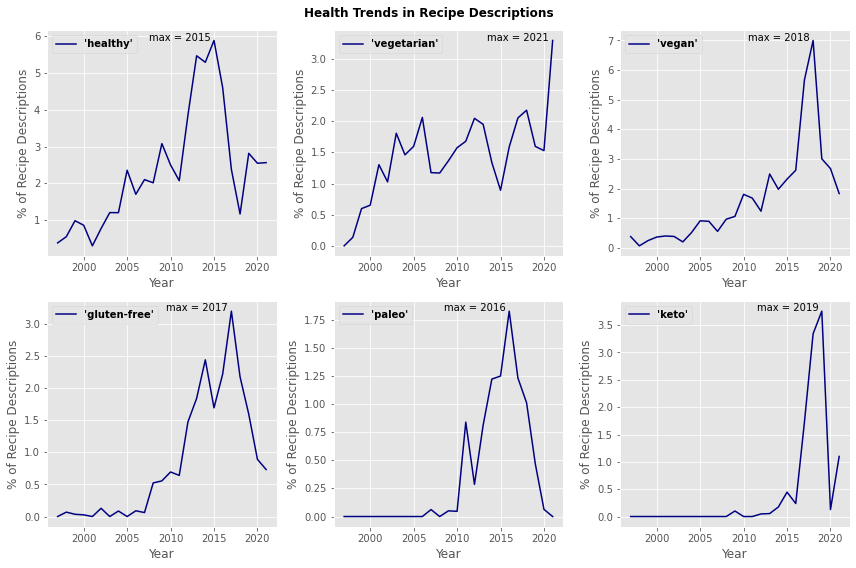

In [145]:
# Plot of recipe description keywords over time
import matplotlib as mpl
mpl.rcParams['font.size'] = 18
plt.style.use('ggplot')

fig, axs = plt.subplots(2,3,figsize=(12,8))
labels = ['\'healthy\'','\'vegetarian\'','\'vegan\'','\'gluten-free\'','\'paleo\'','\'keto\'']
legend_properties = {'weight':'bold'}
for i,ax in enumerate(axs.flatten()):
    ax.plot(years, healthwords[i],label=labels[i],color='navy')
    max = np.max(healthwords[i])
    index = np.where(healthwords[i] == max)
    ax.text(index[0][0]+years[0]-7.5,max,'max = ' + str(index[0][0]+years[0]))
    ax.set_xlabel('Year')
    ax.set_ylabel('% of Recipe Descriptions')
    ax.legend(prop=legend_properties)
fig.suptitle('Health Trends in Recipe Descriptions',fontweight='bold')
plt.tight_layout()
plt.show()

In [389]:
##### Nutrition Information in Recipes

# remove units of measurement from nutrition information
df['nutrition.calories'] = df['nutrition.calories'].str.replace(' calories','')
df['nutrition.carbohydrateContent'] = df['nutrition.carbohydrateContent'].str.replace(' g','')
df['nutrition.cholesterolContent'] = df['nutrition.cholesterolContent'].str.replace(' mg','')
df['nutrition.fatContent'] = df['nutrition.fatContent'].str.replace(' g','')
df['nutrition.fiberContent'] = df['nutrition.fiberContent'].str.replace(' g','')
df['nutrition.proteinContent'] = df['nutrition.proteinContent'].str.replace(' g','')
df['nutrition.saturatedFatContent'] = df['nutrition.saturatedFatContent'].str.replace(' g','')
df['nutrition.sodiumContent'] = df['nutrition.sodiumContent'].str.replace(' mg','')
df['nutrition.sugarContent'] = df['nutrition.sugarContent'].str.replace(' g','')

yearly, years = yearly_dataframe(1999,2022,df) # use function to divide the dataframe by year
cols = ['nutrition.calories','nutrition.carbohydrateContent','nutrition.cholesterolContent','nutrition.fiberContent','nutrition.proteinContent','nutrition.saturatedFatContent','nutrition.sodiumContent','nutrition.sugarContent']

# find mean per year of each nutrition column and load it into a matrix named 'nutrition'
nutrition = np.zeros((len(cols),len(yearly)))
for i in range(0,len(cols)):
    for j in range(0,len(yearly)):
        nut = [float(x) for x in yearly[j][cols[i]] if float(x) >= 0]
        nutrition[i][j] = np.mean(nut)

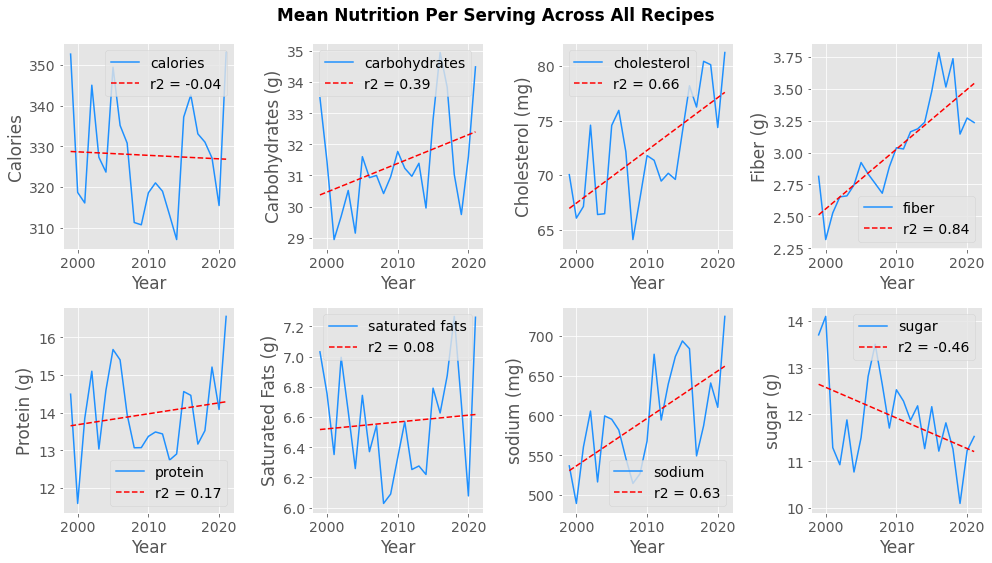

In [213]:
# plot mean per year for each nutrition column over all recipes
fig, axs = plt.subplots(2,4,figsize=(14,8))
labels = ['calories','carbohydrates','cholesterol','fiber','protein','saturated fats','sodium','sugar']
ylabels = ['Calories','Carbohydrates (g)', 'Cholesterol (mg)', 'Fiber (g)','Protein (g)', 'Saturated Fats (g)', 'sodium (mg)','sugar (g)']
for i,ax in enumerate(axs.flatten()):
    ax.plot(years, nutrition[i],label=labels[i],color='dodgerblue')
    ax.set_xlabel('Year')
    ax.set_ylabel(ylabels[i])
    z= np.polyfit(years,nutrition[i],1)
    p = np.poly1d(z)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(years,nutrition[i])
    ax.plot(years,p(years),'r--',label='r2 = ' + str(np.round(r_value,2)))
    ax.legend()
fig.suptitle('Mean Nutrition Per Serving Across All Recipes',fontweight='bold')
plt.tight_layout()
plt.show()


In [214]:
##### Recipe Nutrition Content Analysis

# convert string nutrition columns to floats
cals = [float(x) for x in df['nutrition.calories'] if float(x) >= 0]
meancals = np.mean(cals) # mean calories for all recipes

fat = [float(x) for x in df['nutrition.fatContent'] if float(x) >= 0]
meanfat = np.mean(fat) # mean fat for all recipes in grams

satfat = [float(x) for x in df['nutrition.saturatedFatContent'] if float(x) >= 0]
meansatfat = np.mean(satfat) # mean saturated fat for all recipes in grams

carbs = [float(x) for x in df['nutrition.carbohydrateContent'] if float(x) >= 0]
meancarbs = np.mean(carbs) # mean carbs for all recipes in grams

protein = [float(x) for x in df['nutrition.proteinContent'] if float(x) >= 0]
meanprotein = np.mean(protein) # mean saturated fat for all recipes in grams

sugars = [float(x) for x in df['nutrition.sugarContent'] if float(x) >= 0]
meansugar = np.mean(sugars) # mean saturated fat for all recipes in grams

sodium = [float(x) for x in df['nutrition.sodiumContent'] if float(x) >= 0]
meansodium = np.mean(sodium) # mean sodium for all recipes in milligrams

fiber = [float(x) for x in df['nutrition.fiberContent'] if float(x) >= 0]
meanfiber = np.mean(fiber) # mean fiber for all recipes in grams

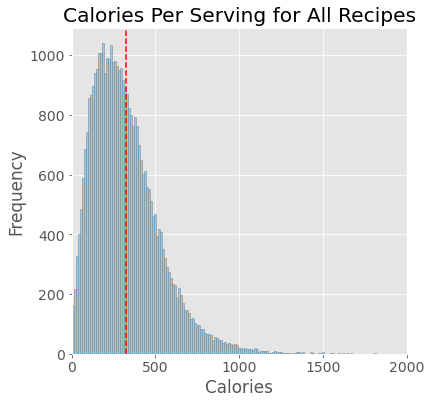

In [453]:
# Plot calorie content of all recipes

fig, ax = plt.subplots(figsize=(6,6))
ax.hist(cals,bins=500,color='lightskyblue',edgecolor='gray')
ax.axvline(meancals,color='red',linestyle='dashed')
ax.set_xlabel('Calories')
ax.set_ylabel('Frequency')
ax.set_title('Calories Per Serving for All Recipes')
ax.set_xlim([0,2000])
plt.show()

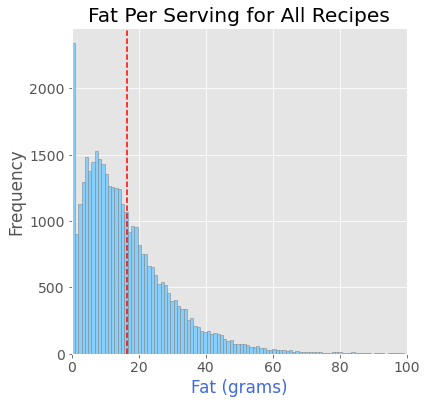

In [454]:
# Plot fat content of all recipes

fig, ax = plt.subplots(figsize=(6,6))
ax.hist(fat,bins=500, color='lightskyblue',edgecolor='gray')
ax.axvline(meanfat,color='red',linestyle='dashed')
ax.set_xlabel('Fat (grams)',color='royalblue')
ax.set_ylabel('Frequency')
ax.set_title('Fat Per Serving for All Recipes')
ax.set_xlim([0,100])
plt.show()

In [215]:
# calculate calories to fat/saturated fats percentage
fatpercent = (meanfat*9)/meancals # multiply mean fat in grams by 9 to get calories from fat, divide by meancals to get percentage of total calories from fat
satfatpercent = (meansatfat*9)/meancals # multiply mean saturated fat in grams by 9 to get calories from saturated fat, divide by meancals to get percentage of total calories from saturated fat

# calculate proportion of calories coming from fats, carbs, protein
proteinpercent = (meanprotein*4)/meancals # multiply mean protein by 4 cals/gram to calculate cals from protein
carbspercent = (meancarbs*4)/meancals # multiply mean carbs by 4 cals/gram to calculate cals from carbs
total = satfatpercent + proteinpercent + carbspercent # should add to around 1

# calculate proportion of calories coming from sugar
sugarpercent = (meansugar*4)/meancals

# calculate grams of sodium and fiber per day if you only ate the mean Allrecipes recipe
servings_per_day = 2000/meancals
sodium_g_per_day = meansodium * servings_per_day # salt per day if you ate the mean Allrecipes recipe every day
fiber_g_per_day = meanfiber * servings_per_day # fiber per day if you ate the mean Allrecipes recipe every day

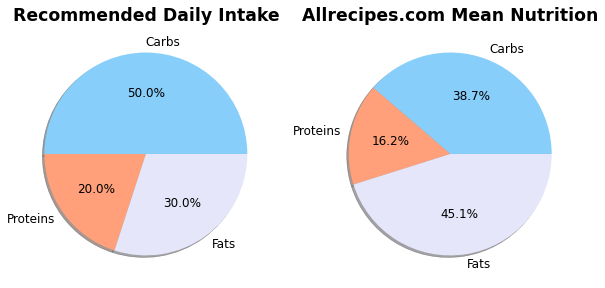

In [216]:
# plots of calories by percentage
import matplotlib as mpl
mpl.rcParams['font.size'] = 12
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,7))
labels = ['Carbs','Proteins','Fats']
colors = ['lightskyblue','lightsalmon','lavender']
recommended = [50,20,30]
actual = [carbspercent,proteinpercent,fatpercent]
ax1.pie(recommended,colors=colors,labels=labels,shadow=True,autopct='%.1f%%')
ax1.set_title('Recommended Daily Intake',fontweight='bold')
ax2.pie(actual,colors=colors,labels=labels,shadow=True,autopct='%.1f%%')
ax2.set_title('Allrecipes.com Mean Nutrition',fontweight='bold')
plt.show()

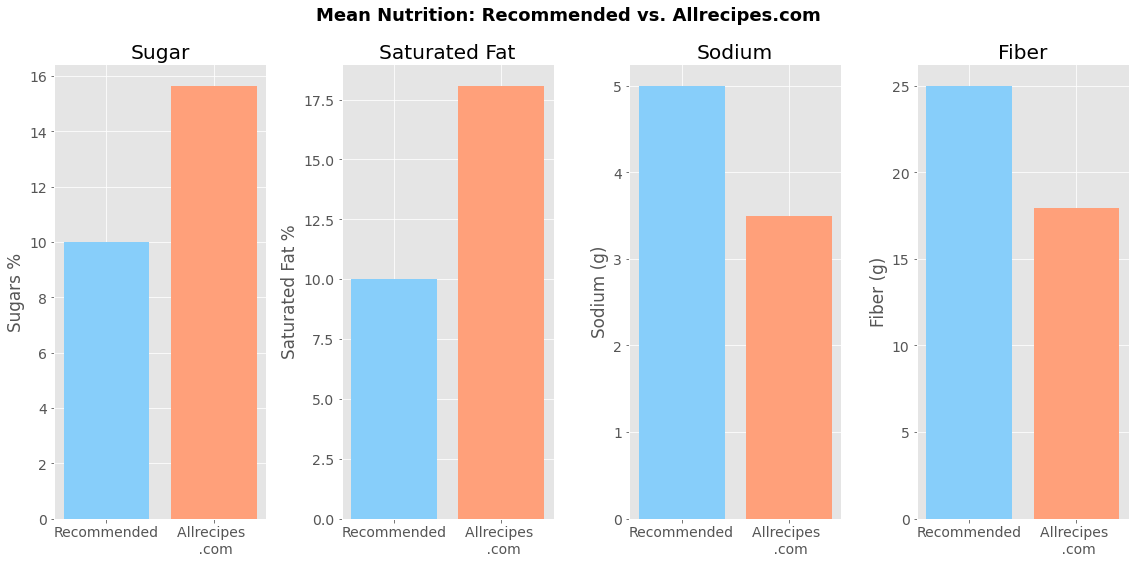

In [217]:
# plots of recommended vs. actual percentage of sugars, saturated fats, salt, and fiber
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
fig, axs = plt.subplots(1,4,figsize=(16,8))
ind = ['Recommended','Allrecipes \n .com']
recommended = [10,10,5,25]
width = 0.5
actual = [sugarpercent*100,satfatpercent*100,sodium_g_per_day/1000,fiber_g_per_day]
titles = ['Sugar','Saturated Fat','Sodium','Fiber']
ylabels = ['Sugars %', 'Saturated Fat %', 'Sodium (g)', 'Fiber (g)']
for i,ax in enumerate(axs.flatten()):
    ax.bar(ind[0],recommended[i],color='lightskyblue')
    ax.bar(ind[1],actual[i],color='lightsalmon')
    ax.set_title(titles[i])
    ax.set_ylabel(ylabels[i])
fig.suptitle('Mean Nutrition: Recommended vs. Allrecipes.com',fontsize = 18, fontweight='bold')
plt.tight_layout()
plt.show()

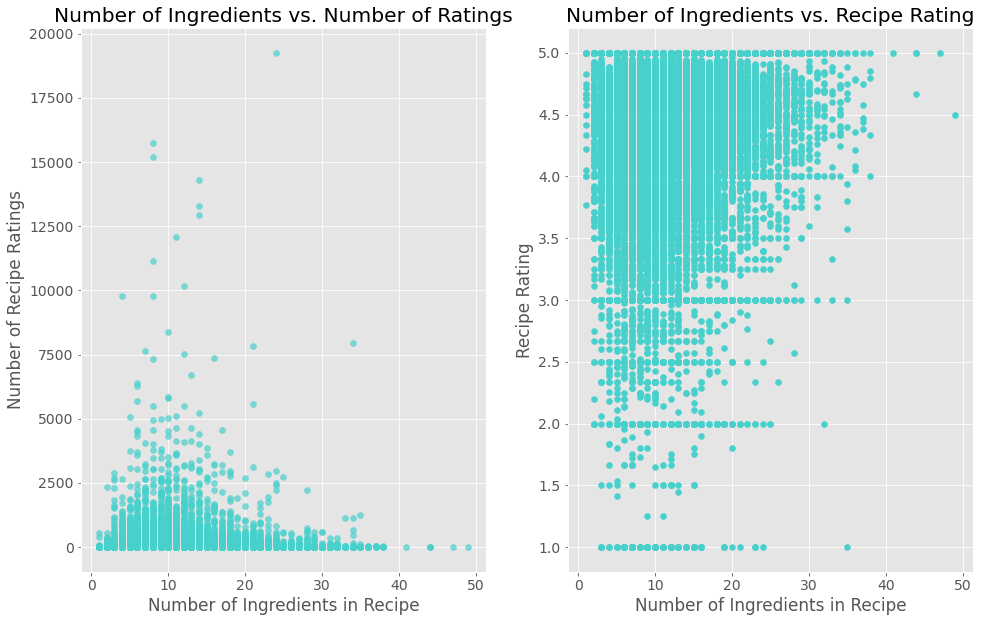

In [483]:
##### Ingredients vs. ratings

num_ingredients = [len(x.split(',')) for x in df['recipeIngredient']] # number of ingredients per recipe
rating_count = df['aggregateRating.ratingCount'] # number of ratings per recipe
rating = df['aggregateRating.ratingValue'] # average rating per recipe

# plot number of ingredients vs. number of ratings and mean rating
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,10))
ax1.scatter(num_ingredients,rating_count, color='mediumturquoise',alpha=0.7)
ax1.set_xlabel('Number of Ingredients in Recipe')
ax1.set_ylabel('Number of Recipe Ratings')
ax1.set_title('Number of Ingredients vs. Number of Ratings')
ax2.scatter(num_ingredients,rating, color='mediumturquoise')
ax2.set_xlabel('Number of Ingredients in Recipe')
ax2.set_ylabel('Recipe Rating')
ax2.set_title('Number of Ingredients vs. Recipe Rating')
plt.show()


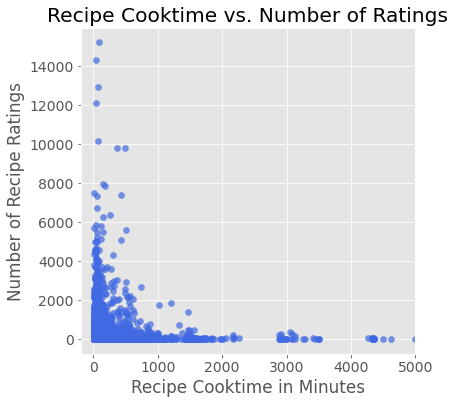

In [482]:
# Total cooking time vs. number of ratings - does cook time correlate with how many people try and rate the recipe?

df_cooktime = df[~df['totalTime'].isna()]
cooktimes = [x for x in df_cooktime['totalTime']]
ratings = [x for x in df_cooktime['aggregateRating.ratingCount']]

cooktimes_minutes = [((int(x.split('P')[1].split('D')[0])*1440)+(int(x.split('T')[1].split('H')[0])*60)+(int(x.split('H')[1].split('M')[0])))  for x in df_cooktime['totalTime']]

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(cooktimes_minutes,ratings,color='royalblue',alpha=0.7)
ax.set_xlabel('Recipe Cooktime in Minutes')
ax.set_ylabel('Number of Recipe Ratings')
ax.set_title('Recipe Cooktime vs. Number of Ratings')
ax.set_xlim([-200,5000])
plt.show()


In [396]:
# Recipe Categories

cat_list = []
arr = df['recipeCategory'].to_numpy()
for i in range(0,len(arr)):
        for j in range(0,len(arr[i])):
            cat_list.append(arr[i][j]) # make list of all categories in sublists

unique_categories = list(set(cat_list)) # list of unique categories
result = sorted([(x, cat_list.count(x)) for x in unique_categories], key=lambda y: y[1]) # list of category name with the count of how many recipes were listed with that category
#for elem in result:
    #print('{} {}'.format(elem[0], elem[1]))

top_20 = result[-20:]
print('The top 20 categories for all recipes in the dataset are :')
for elem in top_20:
    print('{} {}'.format(elem[0], elem[1]))

The top 20 categories for all recipes in the dataset are :
Pork 1220
Drinks Recipes 1391
European 1598
Bread 1737
Cookies 1791
Chicken 1795
Soup Recipes 1817
Trusted Brands: Recipes and Tips 1828
Breakfast and Brunch Recipes 1840
Sauces and Condiments Recipes 1856
Vegetables 1944
Salad 2006
Meat and Poultry Recipes 2658
Stews and Chili Recipes 2740
Soups 2741
Appetizers and Snacks 2920
Main Dish Recipes 2984
World Cuisine Recipes 3690
Side Dish 4618
Dessert Recipes 6824


In [457]:
# Hypothesis testing

# 2-tailed t-test
# H0: Recipe category has no influence on the saturated fat to calories ratio of the recipes in each category
# HA: Recipe category influences the saturated fat to calories ratio of recipes in each category

# alpha significance level is set to 0.05, since this is a standard level and there are not major repercussions in the case that the null hypothesis is incorrectly accepted or rejected.

def hypothesis_test(cat1,cat2,nutrition1,nutrition2,conv,comparison_string,df,alpha):
    
    exploded_categories = df.explode('recipeCategory').reset_index() # explode dataframe so each category in a recipe has its own row

    category1 = exploded_categories[exploded_categories['recipeCategory'] == cat1] # find only dataframe rows with category1
    category2 = exploded_categories[exploded_categories['recipeCategory'] == cat2] # find only dataframe rows with category2

    cat1_nut1 = [float(x)*conv for x in category1[nutrition1]] # multiply by conversion factor (for example fat is 9 calories per gram so conv would be 9)
    cat1_nut2 = [float(x) for x in category1[nutrition2]]
    cat2_nut1 = [float(x)*conv for x in category2[nutrition1]]
    cat2_nut2 = [float(x) for x in category2[nutrition2]]

    cat1_ratio = [x/y for x,y in zip(cat1_nut1,cat1_nut2) if (y > 1)]
    cat1_ratio = [x for x in cat1_ratio if x < 1] # remote any values greater than 1 as these are errors grams of fat cannot be greater than calories since fat has 9 cals/gram

    cat2_ratio = [x/y for x,y in zip(cat2_nut1,cat2_nut2) if (y > 1)]
    cat2_ratio = [x for x in cat2_ratio if x < 1] # remote any values greater than 1 as these are errors grams of fat cannot be greater than calories since fat has 9 cals/gram  
    
    mean1 = np.mean(cat1_ratio)
    var1 = np.var(cat1_ratio)
    mean2 = np.mean(cat2_ratio)
    var2 = np.var(cat2_ratio)
    
    # 2-tailed t-test to see if dessert category fat/cal ratio is from same population as main dish fat/cal ratio
    test = scipy.stats.ttest_ind(cat1_ratio,cat2_ratio,equal_var=False)
    
    # plot histograms and means
    fig, ax = plt.subplots(figsize=(8,6))
    xweights = 100 * np.ones_like(cat1_ratio) / np.array(cat1_ratio).size
    yweights = 100 * np.ones_like(cat2_ratio) / np.array(cat2_ratio).size
    ax.hist(cat1_ratio,weights = xweights,bins=75,label=cat1,color='royalblue',alpha=0.7)
    ax.hist(cat2_ratio,weights = yweights,bins=75,label=cat2,color='lightsalmon',alpha=0.7)
    ax.axvline(mean1,color='blue',linestyle='--',label=cat1 + ' mean')
    ax.axvline(mean2,color='red',linestyle='--',label=cat2 + ' mean')
    ax.legend()
    ax.set_xlabel(comparison_string + ' Calories to Total Calories Ratio')
    ax.set_ylabel('% of Dataset in Bin')
    plt.show()
    
    
    print('The mean of the first category is ' + str(mean1) + ' and the mean of the second category is ' + str(mean2))
    print('The variance of the first category is ' + str(var1) + ' and the variance of the second category is ' + str(var2))
    
    if test[1] >= alpha:
        print('Since the p-value of ' + str(test[1]) + ' is greater than the significance value of ' + str(alpha) + ' we cannot reject the null hypothesis.')
    else:
        print('Since the p-value of ' + str(test[1]) + ' is less than the significance value of ' + str(alpha) + ' we can reject the null hypothesis.')
    
    return test 

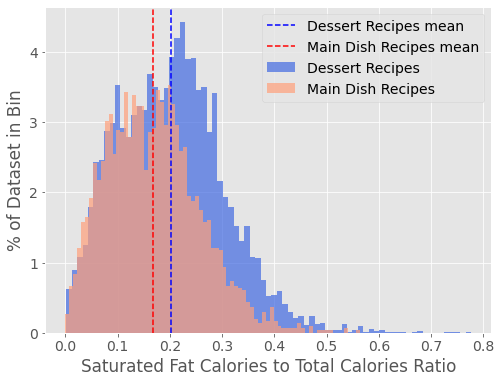

The mean of the first category is 0.20175024402720418 and the mean of the second category is 0.16827284297026385
The variance of the first category is 0.010445635846903728 and the variance of the second category is 0.007705472249667424
Since the p-value of 2.1130871989165067e-59 is less than the significance value of 0.05 we can reject the null hypothesis.


Ttest_indResult(statistic=16.417905633524033, pvalue=2.1130871989165067e-59)

In [458]:
# H0: That recipe category does not influence the saturated fat calories to total calories ratio 
# HA: That the recipes in the 'Dessert' category will have a different saturated fat calories to total calories ratio than the 'Main Dish' category

hypothesis_test('Dessert Recipes','Main Dish Recipes','nutrition.saturatedFatContent','nutrition.calories',9,'Saturated Fat',df,0.05)

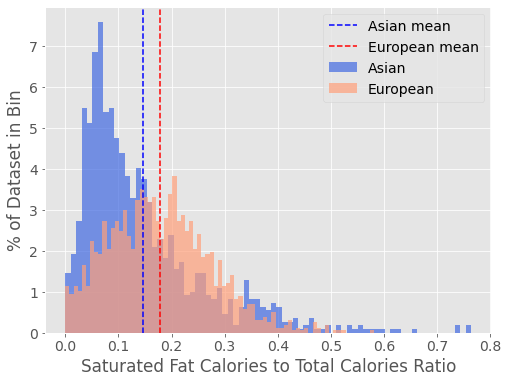

The mean of the first category is 0.14530348485516198 and the mean of the second category is 0.1782581065728772
The variance of the first category is 0.013944887353580727 and the variance of the second category is 0.009136160361360323
Since the p-value of 3.241899360589286e-14 is less than the significance value of 0.05 we can reject the null hypothesis.


Ttest_indResult(statistic=-7.6434898260482935, pvalue=3.241899360589286e-14)

In [412]:
# H0: That recipe category does not influence the saturated fat calories to total calories ratio 
# HA: That the recipes in the 'Asian' category will have a different saturated fat calories to total calories ratio than the 'European' category

hypothesis_test('Asian','European','nutrition.saturatedFatContent','nutrition.calories',9,'Saturated Fat',df,0.05)

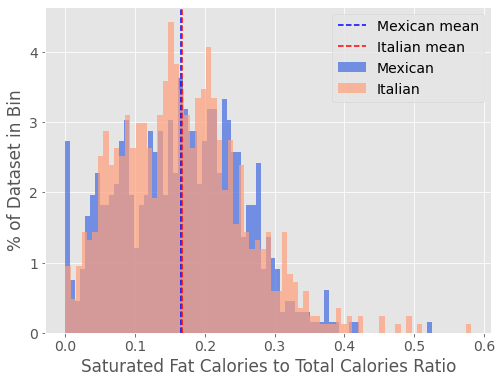

The mean of the first category is 0.16528225389414747 and the mean of the second category is 0.16732257017649915
The variance of the first category is 0.0076146049703401 and the variance of the second category is 0.0078513898322142
Since the p-value of 0.6558939012989302 is greater than the significance value of 0.05 we cannot reject the null hypothesis.


Ttest_indResult(statistic=-0.44568314291114725, pvalue=0.6558939012989302)

In [413]:
# H0: That recipe category does not influence the saturated fat calories to total calories ratio 
# HA: That the recipes in the 'Italian' category will have a different saturated fat calories to total calories ratio than the 'Mexican' category

hypothesis_test('Mexican','Italian','nutrition.saturatedFatContent','nutrition.calories',9,'Saturated Fat',df,0.05)

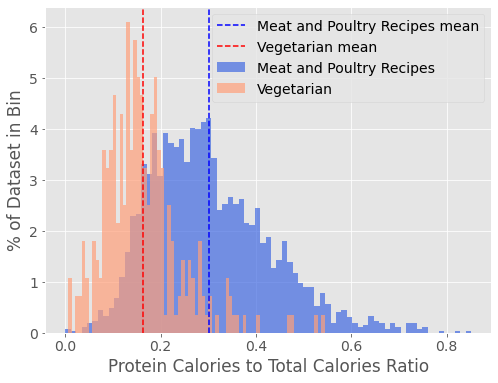

The mean of the first category is 0.30229749160739516 and the mean of the second category is 0.16223765933828957
The variance of the first category is 0.01584690447583834 and the variance of the second category is 0.006736934602485519
Since the p-value of 6.463577754327421e-88 is less than the significance value of 0.05 we can reject the null hypothesis.


Ttest_indResult(statistic=25.487429771711145, pvalue=6.463577754327421e-88)

In [414]:
# H0: That recipe category does not influence the calories from protein to total calories ratio 
# HA: That the recipes in the 'Vegetarian' category will have a different calories from protein to total calories ratio than the 'Meat and Poultry' category

hypothesis_test('Meat and Poultry Recipes','Vegetarian','nutrition.proteinContent','nutrition.calories',4,'Protein',df,0.05)

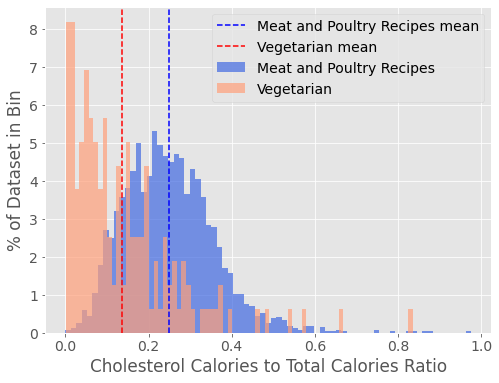

The mean of the first category is 0.24988273326236488 and the mean of the second category is 0.1362790110835013
The variance of the first category is 0.011960488153887226 and the variance of the second category is 0.017694875440441026
Since the p-value of 2.749391022530066e-20 is less than the significance value of 0.05 we can reject the null hypothesis.


Ttest_indResult(statistic=10.524744227510396, pvalue=2.749391022530066e-20)

In [415]:
# H0: That recipe category does not influence the calories from protein to total calories ratio 
# HA: That the recipes in the 'Vegetarian' category will have a different cholesterol to calories ratio than the 'Meat and Poultry' category

hypothesis_test('Meat and Poultry Recipes','Vegetarian','nutrition.cholesterolContent','nutrition.calories',1,'Cholesterol',df,0.05)

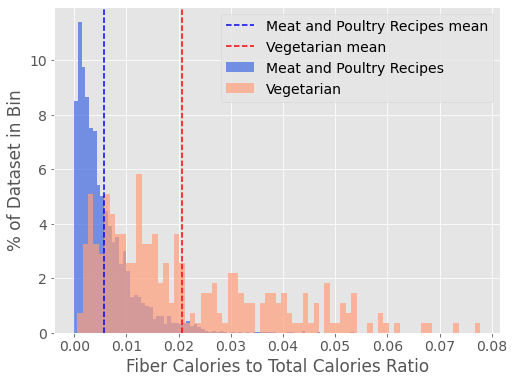

The mean of the first category is 0.0056541054732549955 and the mean of the second category is 0.02064451363855513
The variance of the first category is 3.143332293570614e-05 and the variance of the second category is 0.00026300785073523535
Since the p-value of 1.6568841605208783e-38 is less than the significance value of 0.05 we can reject the null hypothesis.


Ttest_indResult(statistic=-15.203898578892542, pvalue=1.6568841605208783e-38)

In [416]:
# H0: That recipe category does not influence the calories from protein to total calories ratio 
# HA: That the recipes in the 'Vegetarian' category will have a different fiber to calories ratio than the 'Meat and Poultry' category

hypothesis_test('Meat and Poultry Recipes','Vegetarian','nutrition.fiberContent','nutrition.calories',1,'Fiber',df,0.05)

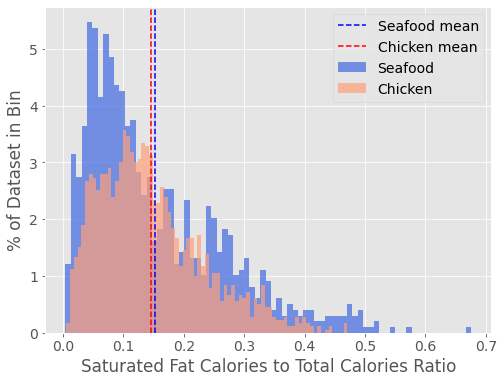

The mean of the first category is 0.15218703038873432 and the mean of the second category is 0.14560642346931063
The variance of the first category is 0.013031047623511219 and the variance of the second category is 0.007546564885768895
Since the p-value of 0.11514168810556215 is greater than the significance value of 0.05 we cannot reject the null hypothesis.


Ttest_indResult(statistic=1.5763424827044672, pvalue=0.11514168810556215)

In [440]:
# H0: That recipe category does not influence the calories from protein to total calories ratio 
# HA: That the recipes in the 'Seafood' category will have a different saturated fat calories to calories ratio than the 'Chicken' category

hypothesis_test('Seafood','Chicken','nutrition.saturatedFatContent','nutrition.calories',9,'Saturated Fat',df,0.05)

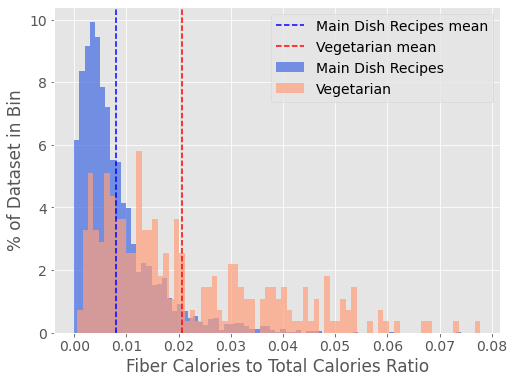

The mean of the first category is 0.007968255683444309 and the mean of the second category is 0.02064451363855513
The variance of the first category is 5.495230587209537e-05 and the variance of the second category is 0.00026300785073523535
Since the p-value of 5.458773299235978e-30 is less than the significance value of 0.05 we can reject the null hypothesis.


Ttest_indResult(statistic=-12.814030883122722, pvalue=5.458773299235978e-30)

In [424]:
# H0: That recipe category does not influence the calories from protein to total calories ratio 
# HA: That the recipes in the 'Main Dish' category will have a different fiber to calories ratio than the 'Vegetarian' category

hypothesis_test('Main Dish Recipes','Vegetarian','nutrition.fiberContent','nutrition.calories',1,'Fiber',df,0.05)